# Lập trình thống kê sử dụng Python

# Kiểm định Friedman

### BS. Lê Ngọc Khả Nhi


# Giới thiệu

Các bạn thân mến, trong bài thực hành hôm nay Nhi sẽ hướng dẫn các bạn dùng Python OOP để lập trình thủ công một quy trình kiểm định phi tham số cho phép đo lặp lại (Friedman test).

Kiểm định Friedman được nhà thống kê và kinh tế học người Mỹ Milton Friedman (1912 –2006) thiết kế và công bố vào năm 1940, như một giải pháp phi tham số thay thế cho ANOVA phép đo lặp lại, khi dữ liệu có những vi phạm giả định kỹ thuật (Nhi đã bàn về kỹ thuật ANOVA này trong bài trước).

Một cách tóm tắt, kiểm định Friedman áp dụng được cho tất cả các thiết kế thí nghiệm mà ta đã bàn trong bài ANOVA phép đo lặp lại nếu dữ liệu không thỏa mãn các giả định của ANOVA truyền thống.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Công cụ
import pandas as pd
import numpy as np

# Đồ họa
import seaborn as sns
import matplotlib.pyplot as plt

# Thống kê
from scipy.stats import f as f_test, shapiro as sw

from itertools import combinations

import scipy.stats as ss

from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.libqsturng import psturng

# Thí dụ minh họa

## Thí nghiệm

Bài thực hành sử dụng dữ liệu từ một thí nghiệm sinh lý có thật trên mô hình động vật. Clostridium ramosum, một loại trực khuẩn đường ruột có đặc tính bất động, gram dương, kị khí. Có giả thuyết cho rằng loại vi khuẩn này góp phần làm tăng nguy cơ bệnh béo phì do gây tăng hấp thu đường và lipid. Một nghiên cứu sinh muốn kiểm chứng giả thuyết này trên chuột, cô đã tiến hành thí nghiệm như sau: 

11 cá thể chuột nhắt sơ sinh được gây nhiễm khuẩn Clostridium ramosum. Sau đó những con chuột này được theo dõi cân nặng mỗi 6 ngày trong vòng 1 tháng (6 lần đo). Cô bác sĩ muốn khảo sát sự thay đổi về cân nặng giữa các thời điểm. 

Dữ liệu gốc dùng cho SPSS, có thể tải từ:

https://github.com/kinokoberuji/Statistics-Python-Tutorials/raw/master/Friedman%20data.sav

## Tải dữ liệu

Nhi viết 1 hàm đọc file SAV (dữ liệu gốc có dạng bảng ngang (wide format)), và recode lại tên biến, chuyển từ bảng ngang thành bảng dọc (long format), sau đó xuất ra cả 2 định dạng long và wide.

In [2]:
def data_prepare():
    subj = 'Animal'
    cond = [f'T{i+1}' for i in range(6)]
    
    wdf = pd.read_spss('Friedman data.sav')
    wdf.columns = cond
    
    wdf[subj] = [f'M{i}' for i in wdf.index]
    
    ldf = pd.melt(wdf, id_vars = [subj], 
                  value_vars = cond,
                  value_name = 'Weight',
                  var_name = 'Time')
    
    ldf[subj]= ldf[subj].astype('object')
    
    return ldf, wdf.drop(['Animal'], axis = 1)

In [4]:
ldf, wdf = data_prepare()

Dữ liệu long format như sau: 

In [5]:
ldf

,Animal,Time,Weight
0,M0,T1,1.2
1,M1,T1,1.3
2,M2,T1,1.3
3,M3,T1,1.3
4,M4,T1,1.4
...,...,...,...
61,M6,T6,19.8
62,M7,T6,18.8
63,M8,T6,17.4
64,M9,T6,20.8


Còn đây là dữ liệu wide format

In [6]:
wdf

,T1,T2,T3,T4,T5,T6
0,1.2,3.2,5.4,7.9,13.4,19.0
1,1.3,3.0,5.0,6.4,13.1,18.2
2,1.3,2.5,6.0,8.2,14.5,22.4
3,1.3,3.2,4.6,6.0,13.8,21.5
4,1.4,2.6,5.7,7.8,12.6,19.0
5,1.5,2.5,5.6,6.5,12.7,19.5
6,1.3,3.2,4.7,7.0,11.8,19.8
7,1.2,3.6,5.8,7.3,13.4,18.8
8,1.3,3.3,5.4,8.0,14.6,17.4
9,1.3,2.8,5.4,6.2,14.2,20.8


## Thăm dò dữ liệu

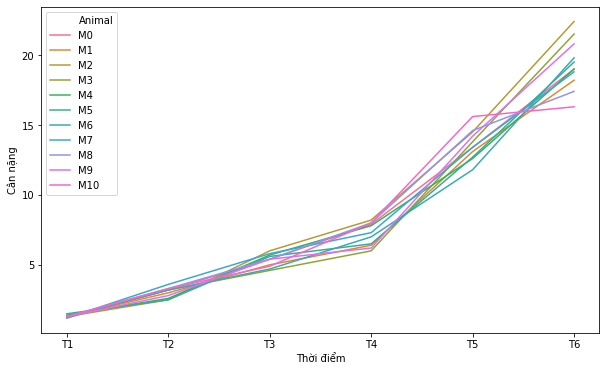

In [7]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams.update({'font.size': 10})
pal = sns.color_palette("husl", wdf.shape[0]).as_hex()

sns.lineplot(data = ldf, x = 'Time', 
             y = 'Weight', 
             hue = 'Animal',
            palette = pal)

plt.ylabel('Cân nặng')
plt.xlabel('Thời điểm')
plt.show()

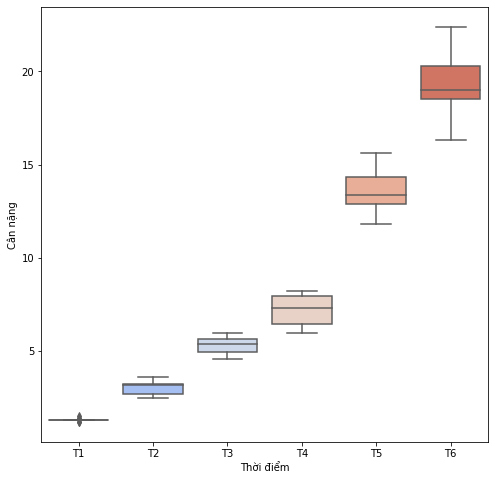

In [8]:
plt.rcParams["figure.figsize"] = (8,8)

sns.boxplot(data = ldf, 
               x = 'Time', 
               y = 'Weight', 
               palette='coolwarm')
plt.ylabel('Cân nặng')
plt.xlabel('Thời điểm')
plt.show()

Thống kê mô tả

In [11]:
ldf.groupby('Time').describe()['Weight']

,count,mean,std,min,25%,50%,75%,max
Time,,,,,,,,
T1,11.0,1.309091,0.083121,1.2,1.30,1.3,1.30,1.5
T2,11.0,3.018182,0.368288,2.5,2.70,3.2,3.25,3.6
T3,11.0,5.318182,0.460040,4.6,4.95,5.4,5.65,6.0
T4,11.0,7.209091,0.821529,6.0,6.45,7.3,7.95,8.2
T5,11.0,13.609091,1.076526,11.8,12.90,13.4,14.35,15.6
T6,11.0,19.336364,1.767073,16.3,18.50,19.0,20.30,22.4


# Quy trình kiểm định Friedman và hậu kiểm

## Kiểm định F

Quy trình kiểm định F phi tham số theo Friedman như sau:
    
1) Đầu tiên, dữ liệu được trình bày theo dạng bảng ngang (wide format), gồm n hàng và k cột; mỗi hàng biểu thị cho một cá thể i (hay còn gọi là block, group), mỗi cột biểu thị cho 1 điều kiện/lượt khảo sát j. Mỗi ô chứa giá trị Yij

2) Xếp hạng: trên mỗi hàng (cá thể), ta xếp hạng Yij thành Rij, theo thứ tự từ thấp đến cao, như vậy Yij thấp nhất có Rij min = 1, Yij cao nhất có Rij max = k. Nếu 2 ô có giá trị Yjj bằng nhau, chúng sẽ cùng nhận giá trị thứ hạng trung bình. 

3) Tính trị số thống kê F, có 3 cách làm:

+ Cách tính xấp xỉ:

$$F = \frac{12}{nk(k+1)}\sum_{j=1}^{k}R_{j}^{2} - 3n(k+1)$$

trong đó, k là số điều kiện, n là số trường hợp, $R_{j}^{2}$ là bình phương tổng thứ hạng cho một phân nhóm j (j=1,2,3...k)

+ Cách tính chính xác:

Đấu tiên, tính thứ hạng trung bình cho từng điều kiện j:

$$\bar{r_{j}} = \frac{1}{n}\sum_{i=1}^{n}r_{ji}$$

Sau đó tính thứ hạng trung bình cho n cá thể/k phân nhóm:

$$\bar{r_{}} = \frac{1}{nk}\sum_{i=1}^{n} \sum_{j=1}^{k}r_{ji}$$

Sau đó tính tổng bình phương sai số do yếu tố điều kiện SST:

$$SST = n\sum_{j=1}^{k} (\bar{r_{j}} - \bar{r})^{2}$$

Sau đó, tính tổng bình phương sai số SSE:

$$SSE = \frac{1}{n(k-1)}\sum_{i=1}^{n} \sum_{j=1}^{k}(r_{ij} - \bar{r})^{2}$$

Từ SST và SSE, ta tính được F:

$$F =  \frac{SST}{SSE}$$

Như vậy, có thể nhận ra ý nghĩa của trị số F phi tham số dựa vào thứ hạng cũng giống như F dựa vào giá trị gốc (Yij) trong ANOVA.

Hai trị số F trên của Friedman được giả định phân bố theo quy luật $\chi^{2})$ với độ tự do = (k-1)

+ Vào năm 1980, Iman và Davenport cho rằng trị số F của Friedman là quá bảo thủ, nên đề xuất một phương pháp hoán chuyển như sau:

$$F' =  \frac{(n-1)F}{n(k-1) - F}$$

Khác với F của Friedman, F' theo phân bố F giống như kiểm định F của Fisher, ở 2 độ tự do k=1 và (k-1)(n-1)

4) Suy diễn thống kê: 

Kiểm định Friedman không nhằm so sánh trung bình hay trung vị như ta thường nghĩ, nhưng nhằm kiểm tra liệu biến kết quả Yj có tương đồng về đặc tính phân phối ở mỗi phân nhóm điều kiện (j) hay không.

H0 có thể được phát biểu: Đặc tính phân phối của Y không thay đổi tại mỗi điều kiện khảo sát J (hay Y không thay đổi theo thời gian, nếu J có yếu tố thời gian; hoặc: Điều kiện khảo sát j không có ảnh hưởng ý nghĩa  đối với Y.

Giả thuyết đối nghịch như vậy sẽ là: Có ít nhất 2 phân nhóm Yj khác biệt về đặc tính phân phối, hay: điều kiện J gây hiệu ứng có ý nghĩa làm thay đổi Y.

Để phủ định H0, ta tính giá trị p dựa vào phân phối Chi bình phương với độ tự do k-1 nếu dùng F theo Friedman, hoặc phân phối F nếu dùng F' của Iman và Davenport, ở 2 độ tự do k=1 và (k-1)(n-1).

Giá trị p là xác suất quan sát được F <= $\chi^{2})$ ở độ tự do df = k-1 nếu H0 là đúng.

Với ngưỡng alpha = 0.05, nếu p < 0.05 ta có thể phủ định H0.

## Posthoc test

Nếu F test cho kết quả dương tính (phủ định được H0), ta chỉ mới khẳng định được hiệu ứng ý nghĩa của điều kiện đo hay thời gian (J) đối với Y, nhưng chưa định vị được khác biệt giữa các cặp phân nhóm, để trả lời câu hỏi này, ta sẽ thực hiện 1 phân tích hậu kiểm (post-hoc).

Có nhiều phương pháp post-hoc test phi tham số cho thí nghiệm lặp lại, nhưng trong bài thực hành này Nhi sẽ áp dụng 4 phương pháp, gồm:


+ post-hoc test Nemenyi (1963): dựa vào trị số khác biệt thứ hạng chuẩn hóa q:

$$q = \frac{\bar{R_{a}} -\bar{R_{b}}}{\sqrt{\frac{k(k+1)}{6n}}}$$

Suy diễn thống kê dựa vào phân phối Student t, cho tích giữa q và căn 2

+ post-hoc test Conover, dựa vào trị số thống kê t, phân phối Student's t với độ tự do = n*k - k - n + 1


+ post_hoc test Siegel_Castellan, sử dụng giá trị gốc của q (Z-score), và suy diễn thống kê dựa vào phân phối chuẩn


+ post-hoc test Miller, là một biến thể của Nemenyi, nhưng sử dụng giá trị q bình phương, suy diễn thống kê theo phân phối $\chi^{2}$ với độ tự do k-1

# Lập trình thủ công Friedman test

Nhi tạo 1 class tên là Friedman để thi hành 1 quy trình kiểm định Friedman hoàn chỉnh;

1 object thuộc class này có thể được khởi tạo bằng 3 cách: 

1) Sử dụng bảng dọc (long format), lúc này dùng những arguments như sau: 

df_format = 'long', var_name = None, subj = tên cột chỉ mã số định danh cá thể, cond = tên cột chỉ yếu tố can thiệp (lượt đo, thời gian, điều kiện đo), target = tên cột chỉ biến kết quả Y

2) Sử dụng bảng ngang (wide format), với arguments như sau:

df_format = 'wide', var_name = 1 cái tên tùy thích chỉ yếu tố can thiệp (lượt đo, thời gian, điều kiện đo), subj = None, cond = 1 list chứa tên những cột phân nhóm cần khảo sát (lượt đo, điều kiện, phân nhóm can thiệp), target = tên biến kết quả Y, tùy ý.

3) Sử dụng công thức trên 1 bảng dọc, thông qua class method 'from_formula': Y ~ C | S với Y là tên biến kết quả, C là tên yếu tố can thiệp (phân nhóm), S là tên của yếu tố cá thể (thí dụ Animal, Patient, Subject) trong dataframe long format.

Hàm init sẽ tạo ra 1 object với 3 thuộc tính là 1 dataframe long format, 1 dataframe wide format (vì wide format sẽ tiện dụng để làm F test, trong khi long format tiện dụng để làm post hoc test), và 1 list chứa tên cond, subj,target.

Class này có 5 method, lần lượt làm F test theo Friedman bằng 3 cách tính, và 4 loại post-hoc test khác nhau.

Nôi dung code như sau:

In [26]:
class Friedman:
    
    def __init__(self, df, df_format = 'long', var_name = None,
                 subj=None, cond=None, target=None):
        
        if df_format == 'wide':
            df[subj] = df.index
            ldf = pd.melt(df, id_vars = [subj], 
                          value_vars = cond,
                          value_name = target,
                          var_name = var_name
                         )
            ldf[subj]= ldf[subj].astype('object')
            
            wdf = df.drop([subj], axis = 1)
            cond = var_name
                        
        if df_format == 'long':
            wdf = df.pivot(index = subj, 
                          columns = cond,
                          values = target)
            
            ldf = df[[subj, cond, target]]
    
        self.ldf = ldf.dropna(how = 'any', axis = 0)
        self.wdf = wdf.dropna(how = 'any', axis = 0)
        
        self.params = [cond, subj,target]
    
    @classmethod
    def from_formula(cls, df, formula = 'Y ~ C | G'):
        target = formula.split('~')[0].strip()
        cond = formula.split('~')[1].split('|')[0].strip()
        subj = formula.split('~')[1].split('|')[1].strip()
        
        return cls(df = df, 
                   df_format = 'long', 
                   var_name = cond,
                   subj=subj, 
                   cond=cond, 
                   target=target)
            
    def __repr__(self):
        return f"Kiểm định Friedman với k={self.wdf.shape[1]}, n={self.wdf.shape[0]}"
    
    def F_test(self, alpha = 0.05):
        data = self.wdf
        
        stat = pd.DataFrame(index=['Friedman xấp xỉ',
                                   'Friedman chính xác',
                                   'Iman-Davenport'])
        
        X = data.values
        conds = list(data.columns)
        n,k = data.shape
        
        # Tính Friedman Chisquared test
        
        rank_mat = np.zeros(X.shape)
        
        for i in range(n):
            rank_mat[i] = ss.rankdata(X[i, :])
        
        # Phương pháp xấp xỉ
        ssb = (rank_mat.sum(axis=0)**2).sum()
        F_approx = (12 / (n * k * (k + 1))) * ssb - 3 * n * (k + 1)
        
        # Phương pháp chính xác
        rj = rank_mat.mean(axis = 0)
        rm = rank_mat.mean()
        SST = n*((rj - rm)**2).sum()
        SSE = ((rank_mat-rm)**2).sum()/(n*(k-1))
        
        F_exact = SST/SSE
        
        # Hiệu chỉnh thứ hạng bằng nhau
        ties = 0
        for i in range(n):
            replist, repnum = ss.find_repeats(X[i])
            for t in repnum:
                ties += t * (t * t - 1)
        c = 1 - ties / float(k * (k * k - 1) * n)
        
        F_approx /= c
        F_exact /= c
        
        dof = (k - 1)
        
        p1 = ss.chi2.sf(F_approx, dof)
        p2 = ss.chi2.sf(F_exact, dof)
        
        # Iman-Davenport F test
        
        Fc = ((n - 1)*F_approx)/(n*(k-1) - F_approx)
        
        dof_1 = k-1
        dof_2 = (k-1)*(n-1)
        
        p3 = f_test.sf(Fc, dof_1, dof_2)
        
        stat['F'] = [F_approx,F_exact,Fc]
        stat['Độ tự do'] = [str(dof), str(dof), str(f'({dof_1},{dof_2})')]
        stat['Giá trị p'] = [p1, p2,p3]
        
        stat['Phủ định H0'] = ['Có thể' if i else 'Không thể' for i in stat['Giá trị p'] < alpha]
        
        return stat
    
    def Nemenyi_test(self):
        df = self.ldf
        cond, subj, target = self.params
        
        groups = df[cond].unique()
        k = groups.size
        n = df[subj].unique().size
        
        df['Rank'] = df.groupby(subj)[target].rank()
        
        R = df.groupby(cond)['Rank'].mean()
        
        vs = np.zeros((k, k))
        combs = combinations(range(k), 2)
        
        def nemenyi_stats(i, j):
            dif = np.abs(R[groups[i]] - R[groups[j]])
            qval = dif / np.sqrt(k * (k + 1.) / (6. * n))
            return qval
        
        tri_upper = np.triu_indices(vs.shape[0], 1)
        tri_lower = np.tril_indices(vs.shape[0],-1)
        vs[:, :] = 0

        for i, j in combs:
            vs[i, j] = nemenyi_stats(i, j)
            
        vs *= np.sqrt(2.)
        vs[tri_upper] = psturng(vs[tri_upper], k, np.inf)
        vs[tri_lower] = vs.T[tri_lower]
        np.fill_diagonal(vs, 1)

        return pd.DataFrame(vs, index=groups, columns=groups)
    
    def Conover_test(self, p_adjust = 'bonferroni'):
        
        df = self.ldf
        cond, subj, target = self.params
        
        groups = df[cond].unique()
        k = groups.size
        n = df[subj].unique().size
        
        df['Rank'] = df.groupby(subj)[target].rank()
        
        R = df.groupby(cond)['Rank'].sum()
        
        def posthoc_conover(i, j):
            dif = np.abs(R.loc[groups[i]] - R.loc[groups[j]])
            tval = dif / np.sqrt(A) / np.sqrt(B)
            pval = 2. * ss.t.sf(np.abs(tval), df=(m*n*k - k - n + 1))
            return pval
        
        A1 = (df['Rank'] ** 2).sum()
        m = 1
        S2 = m/(m*k - 1.) * (A1 - m*k*n*(m*k + 1.)**2./4.)
        T2 = 1. / S2 * (np.sum(R) - n * m * ((m * k + 1.) / 2.)**2.)
        A = S2 * (2. * n * (m * k - 1.)) / (m * n * k - k - n + 1.)
        B = 1. - T2 / (n * (m * k - 1.))
        
        vs = np.zeros((k, k))
        combs = combinations(range(k), 2)

        tri_upper = np.triu_indices(vs.shape[0], 1)
        tri_lower = np.tril_indices(vs.shape[0], -1)
        vs[:, :] = 0
        
        for i, j in combs:
            vs[i, j] = posthoc_conover(i, j)

        if p_adjust:
            vs[tri_upper] = multipletests(vs[tri_upper], method=p_adjust)[1]

        vs[tri_lower] = vs.T[tri_lower]
        np.fill_diagonal(vs, 1)
        
        return pd.DataFrame(vs, index=groups, columns=groups)
    
    def Siegel_Castellan(self, p_adjust = 'bonferroni'):
        
        df = self.ldf
        cond, subj, target = self.params
        
        groups = df[cond].unique()
        k = groups.size
        n = df[subj].unique().size
        
        df['Rank'] = df.groupby(subj)[target].rank()
        
        R = df.groupby(cond)['Rank'].mean()
        
        def posthoc_SC(i, j):
            dif = np.abs(R[groups[i]] - R[groups[j]])
            zval = dif / np.sqrt(k * (k + 1.) / (6. * n))
            return zval
        
        vs = np.zeros((k, k), dtype=np.float)
        combs = combinations(range(k), 2)

        tri_upper = np.triu_indices(vs.shape[0], 1)
        tri_lower = np.tril_indices(vs.shape[0], -1)
        vs[:, :] = 0

        for i, j in combs:
            vs[i, j] = posthoc_SC(i, j)
            
        vs = 2. * ss.norm.sf(np.abs(vs))
        vs[vs > 1] = 1
        
        if p_adjust:
            vs[tri_upper] = multipletests(vs[tri_upper], method=p_adjust)[1]

        vs[tri_lower] = vs.T[tri_lower]
        np.fill_diagonal(vs, 1)

        return pd.DataFrame(vs, index=groups, columns=groups)
    
    def Miller_Friedman(self):
        
        df = self.ldf
        cond, subj, target = self.params
        
        groups = df[cond].unique()
        k = groups.size
        n = df[subj].unique().size
        
        df['Rank'] = df.groupby(subj)[target].rank()
        
        R = df.groupby(cond)['Rank'].mean()
        
        def posthoc_Miller(i, j):
            dif = np.abs(R[groups[i]] - R[groups[j]])
            qval = dif / np.sqrt(k * (k + 1.) / (6. * n))
            return qval
        
        vs = np.zeros((k, k), dtype=np.float)
        combs = combinations(range(k), 2)

        tri_upper = np.triu_indices(vs.shape[0], 1)
        tri_lower = np.tril_indices(vs.shape[0], -1)
        vs[:, :] = 0

        for i, j in combs:
            vs[i, j] = posthoc_Miller(i, j)

        vs = vs ** 2
        vs = ss.chi2.sf(vs, k - 1)
        
        vs[tri_lower] = vs.T[tri_lower]
        np.fill_diagonal(vs, 1)

        return pd.DataFrame(vs, index=groups, columns=groups)

# Sử dụng class Friedman

## Khởi tạo object từ long format

Nhi sẽ thử tải long format data vào class Friedman và xem nó có hoạt động tốt không, kết quả thành công: method init đã hoán chuyển long format thành wide format và lưu cả 2.

In [27]:
case = Friedman(df = ldf, 
                df_format = 'long', 
                subj='Animal', 
                cond='Time', 
                target='Weight')

case

Kiểm định Friedman với k=6, n=11

In [28]:
case.ldf

,Animal,Time,Weight
0,M0,T1,1.2
1,M1,T1,1.3
2,M2,T1,1.3
3,M3,T1,1.3
4,M4,T1,1.4
...,...,...,...
61,M6,T6,19.8
62,M7,T6,18.8
63,M8,T6,17.4
64,M9,T6,20.8


In [29]:
case.wdf

Time,T1,T2,T3,T4,T5,T6
Animal,,,,,,
M0,1.2,3.2,5.4,7.9,13.4,19.0
M1,1.3,3.0,5.0,6.4,13.1,18.2
M10,1.3,3.3,4.9,8.0,15.6,16.3
M2,1.3,2.5,6.0,8.2,14.5,22.4
M3,1.3,3.2,4.6,6.0,13.8,21.5
M4,1.4,2.6,5.7,7.8,12.6,19.0
M5,1.5,2.5,5.6,6.5,12.7,19.5
M6,1.3,3.2,4.7,7.0,11.8,19.8
M7,1.2,3.6,5.8,7.3,13.4,18.8


## Khởi tạo object từ wide format:

Nhi làm tương tự cho wide format dataframe, kết quả cũng thành công:

In [30]:
case = Friedman(df = wdf, 
                df_format = 'wide', 
                subj='Animal', 
                cond= [f"T{i+1}" for i in range(6)],
                var_name = 'Time',
                target='Weight')

case

Kiểm định Friedman với k=6, n=11

In [31]:
case.ldf

,Animal,Time,Weight
0,0,T1,1.2
1,1,T1,1.3
2,2,T1,1.3
3,3,T1,1.3
4,4,T1,1.4
...,...,...,...
61,6,T6,19.8
62,7,T6,18.8
63,8,T6,17.4
64,9,T6,20.8


In [32]:
case.wdf

,T1,T2,T3,T4,T5,T6
0,1.2,3.2,5.4,7.9,13.4,19.0
1,1.3,3.0,5.0,6.4,13.1,18.2
2,1.3,2.5,6.0,8.2,14.5,22.4
3,1.3,3.2,4.6,6.0,13.8,21.5
4,1.4,2.6,5.7,7.8,12.6,19.0
5,1.5,2.5,5.6,6.5,12.7,19.5
6,1.3,3.2,4.7,7.0,11.8,19.8
7,1.2,3.6,5.8,7.3,13.4,18.8
8,1.3,3.3,5.4,8.0,14.6,17.4
9,1.3,2.8,5.4,6.2,14.2,20.8


## Tạo object bằng công thức

Tương tự, Nhi thử tính năng dùng công thức cho bảng dọc: kết quả cũng thành công:

In [33]:
case = Friedman.from_formula(df = ldf, 
                             formula = 'Weight ~ Time | Animal')

case

Kiểm định Friedman với k=6, n=11

In [34]:
case.ldf

,Animal,Time,Weight
0,M0,T1,1.2
1,M1,T1,1.3
2,M2,T1,1.3
3,M3,T1,1.3
4,M4,T1,1.4
...,...,...,...
61,M6,T6,19.8
62,M7,T6,18.8
63,M8,T6,17.4
64,M9,T6,20.8


In [35]:
case.wdf

Time,T1,T2,T3,T4,T5,T6
Animal,,,,,,
M0,1.2,3.2,5.4,7.9,13.4,19.0
M1,1.3,3.0,5.0,6.4,13.1,18.2
M10,1.3,3.3,4.9,8.0,15.6,16.3
M2,1.3,2.5,6.0,8.2,14.5,22.4
M3,1.3,3.2,4.6,6.0,13.8,21.5
M4,1.4,2.6,5.7,7.8,12.6,19.0
M5,1.5,2.5,5.6,6.5,12.7,19.5
M6,1.3,3.2,4.7,7.0,11.8,19.8
M7,1.2,3.6,5.8,7.3,13.4,18.8


## Thực hiện F test

Tiếp theo, Nhi thử làm F test trên 1 object Friedman, kết quả như sau:

In [37]:
case.F_test(alpha = 0.01)

,F,Độ tự do,Giá trị p,Phủ định H0
Friedman xấp xỉ,55.0,5,1.305362e-10,Có thể
Friedman chính xác,55.0,5,1.305362e-10,Có thể
Iman-Davenport,inf,"(5,50)",0.000000e+00,Có thể


Cả 3 phương pháp đều cho ra kết luận là có sự thay đổi ý nghĩa về cân nặng theo thời gian giữa 6 lần đo.

## Post hoc test Conover 

Tiếp theo, Nhi thử làm 1 post hoc test theo phương pháp Conover, với hiệu chỉnh Benjamini/Hochberg, kết quả là 1 ma trận như sau:

In [41]:
case.Conover_test(p_adjust= 'fdr_bh')

,T1,T2,T3,T4,T5,T6
T1,1.000000,0.226930,0.026963,0.001472,0.000054,0.000002
T2,0.226930,1.000000,0.226930,0.026963,0.001472,0.000054
T3,0.026963,0.226930,1.000000,0.226930,0.026963,0.001472
T4,0.001472,0.026963,0.226930,1.000000,0.226930,0.026963
T5,0.000054,0.001472,0.026963,0.226930,1.000000,0.226930
T6,0.000002,0.000054,0.001472,0.026963,0.226930,1.000000


## Post hoc Nemenyi

Tương tự, 1 posthoc test Nemenyi có kết quả như sau

In [42]:
case.Nemenyi_test()

,T1,T2,T3,T4,T5,T6
T1,1.000000,0.784956,0.122178,0.002340,0.001000,0.001000
T2,0.784956,1.000000,0.784956,0.122178,0.002340,0.001000
T3,0.122178,0.784956,1.000000,0.784956,0.122178,0.002340
T4,0.002340,0.122178,0.784956,1.000000,0.784956,0.122178
T5,0.001000,0.002340,0.122178,0.784956,1.000000,0.784956
T6,0.001000,0.001000,0.002340,0.122178,0.784956,1.000000


## Posthoc Miller

In [43]:
case.Miller_Friedman()

,T1,T2,T3,T4,T5,T6
T1,1.000000e+00,0.904683,0.279402,0.014727,0.000131,2.080225e-07
T2,9.046827e-01,1.000000,0.904683,0.279402,0.014727,1.307567e-04
T3,2.794019e-01,0.904683,1.000000,0.904683,0.279402,1.472699e-02
T4,1.472699e-02,0.279402,0.904683,1.000000,0.904683,2.794019e-01
T5,1.307567e-04,0.014727,0.279402,0.904683,1.000000,9.046827e-01
T6,2.080225e-07,0.000131,0.014727,0.279402,0.904683,1.000000e+00


## Post hoc Siegel_Castellan

In [44]:
case.Siegel_Castellan(p_adjust= 'fdr_bh')

,T1,T2,T3,T4,T5,T6
T1,1.000000e+00,0.210000,0.018257,0.000424,0.000003,5.491652e-09
T2,2.099997e-01,1.000000,0.210000,0.018257,0.000424,2.661824e-06
T3,1.825725e-02,0.210000,1.000000,0.210000,0.018257,4.235980e-04
T4,4.235980e-04,0.018257,0.210000,1.000000,0.210000,1.825725e-02
T5,2.661824e-06,0.000424,0.018257,0.210000,1.000000,2.099997e-01
T6,5.491652e-09,0.000003,0.000424,0.018257,0.210000,1.000000e+00


# Diễn đạt văn bản khoa học:

Phương pháp: Sự thay đổi cân nặng của nhóm chuột sau khi gây nhiễm Clostridium ramosum theo thời gian được kiểm tra bằng test phi tham số Friedman (1940) và posh-hoc test XYZ. 

Kết quả: Có sự thay đổi ý nghĩa về cân nặng của nhóm chuột theo thời gian sau khi nhiễm khuẩn ($\chi^{2}$(5) = 55; p < 0.0001. Post hoc test cho thấy hiệu ứng tăng cân trải qua 2 giai đoạn, giai đoạn 1 từ ngày thứ 1 đến ngày thứ 18, kể từ ngày 19, khác biệt cân nặng bắt đầu có ý nghĩa thống kê so với giai đoạn 1. 

# Tổng kết

Bài thực hành đến đây là hết, bạn đã có trong tay một công cụ mới trong ngôn ngữ Python, để áp dụng cho thiết kế nghiên cứu phép đo lặp lại.


# Tài liệu tham khảo:

1) Friedman, Milton (March 1940). "A comparison of alternative tests of significance for the problem of m rankings". The Annals of Mathematical Statistics. 11 (1): 86–92. doi:10.1214/aoms

2) Friedman, Milton (December 1937). "The use of ranks to avoid the assumption of normality implicit in the analysis of variance". Journal of the American Statistical Association. 32 (200): 675–701.

3) Iman,  R.L.,  Davenport,  J.M.,  Approxi-mations of the critical region of the Fried-man statistic,Communications in Statis-tics, Vol. 18, 1980, pp. 571-595.

4) P. Nemenyi (1963) Distribution-free Multiple Comparisons. Ph.D. thesis, Princeton University.

5) W. J. Conover and R. L. Iman (1979), On multiple-comparisons procedures, Tech. Rep. LA-7677-MS, Los Alamos Scientific Laboratory.

6) W. J. Conover (1999), Practical nonparametric Statistics, 3rd. Edition,Wiley.

7) S. Siegel, N. J. Castellan Jr. (1988), Nonparametric Statistics for the Behavioral Sciences. 2nd ed. New York: McGraw-Hill.

8) R. G. Miller Jr. (1996), Simultaneous statistical inference. New York: McGraw-Hill.